In [2]:
import os

DATA_DIR = "StanfordDroneDataset"
directories = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
print(directories)

['little', 'gates', 'coupa', 'hyang', 'deathCircle', 'quad', 'nexus', 'bookstore']


In [3]:
video_dir = f"{os.path.join(DATA_DIR, directories[1])}/video2"
sample_ann = os.path.join(video_dir, "annotations.txt")
reference_image = os.path.join(video_dir, "reference.jpg")
import numpy as np
import pandas as pd
# data = np.genfromtxt(sample_ann, delimiter=' ', dtype="str", encoding='utf-8')
header = ["track", "xmin", "ymin", "xmax", "ymax", "frame", "lost", "occluded", "generated", "label"]
data = pd.read_csv(sample_ann, sep=' ', encoding='utf-8', header=None, names=header)
data

,track,xmin,ymin,xmax,ymax,frame,lost,occluded,generated,label
0,0,793,1035,835,1097,6500,1,0,0,Pedestrian
1,0,793,1035,835,1097,6501,1,0,1,Pedestrian
2,0,793,1035,835,1097,6502,1,0,1,Pedestrian
3,0,793,1035,835,1097,6503,1,0,1,Pedestrian
4,0,793,1035,835,1097,6504,1,0,1,Pedestrian
...,...,...,...,...,...,...,...,...,...,...
99261,124,1,579,23,674,5027,1,0,1,Pedestrian
99262,124,1,579,23,674,5028,1,0,1,Pedestrian
99263,124,1,579,23,674,5029,1,0,1,Pedestrian
99264,124,1,579,23,674,5030,1,0,1,Pedestrian


In [12]:
from tqdm import tqdm

# Find all .txt files in all directories
txt_files = []
for directory in tqdm(directories, desc="Processing directories"):
    dir_path = os.path.join(DATA_DIR, directory)
    if os.path.isdir(dir_path):
        for sub_dir in os.listdir(dir_path):
            sub_dir_path = os.path.join(dir_path, sub_dir)
            if os.path.isdir(sub_dir_path):
                txt_files.extend([os.path.join(sub_dir_path, f) for f in os.listdir(sub_dir_path) if f.endswith('.txt')])

# Load each .txt file and find unique labels
all_labels = set()
for txt_file in tqdm(txt_files, desc="Processing .txt files"):
    data = pd.read_csv(txt_file, sep=' ', encoding='utf-8', header=None, names=header)
    all_labels.update(data['label'].unique())

# Print unique labels
print("Unique labels across all .txt files:", all_labels)

Processing .txt files: 100%|██████████| 60/60 [00:15<00:00,  3.91it/s]

Unique labels across all .txt files: {'Skater', 'Cart', 'Biker', 'Bus', 'Pedestrian', 'Car'}


In [4]:
LABEL_MAPPER = {
    'Skater': 'Cyclist',
    'Bus': 'Bus',
    'Car': 'Car',
    'Cart': 'Van',
    'Biker': 'Cyclist',
    'Pedestrian': 'Pedestrian',
}

In [5]:
data["label"].unique()

array(['Pedestrian', 'Biker', 'Skater'], dtype=object)

In [6]:
data['x'] = (data["xmin"].astype("int") + data["xmax"].astype("int") ) // 2
data['y'] = (data["ymin"].astype("int") + data["ymax"].astype("int") ) // 2
data.drop(columns=["xmin", "ymin", "xmax", "ymax"], inplace=True)
data

,track,frame,lost,occluded,generated,label,x,y
0,0,6500,1,0,0,Pedestrian,814,1066
1,0,6501,1,0,1,Pedestrian,814,1066
2,0,6502,1,0,1,Pedestrian,814,1066
3,0,6503,1,0,1,Pedestrian,814,1066
4,0,6504,1,0,1,Pedestrian,814,1066
...,...,...,...,...,...,...,...,...
99261,124,5027,1,0,1,Pedestrian,12,626
99262,124,5028,1,0,1,Pedestrian,12,626
99263,124,5029,1,0,1,Pedestrian,12,626
99264,124,5030,1,0,1,Pedestrian,12,626


In [7]:
cols = ["frame", "track", "x", "y", "label", "lost", "occluded", "generated"]
data = data[cols]
data.sort_values(by=["frame", "track"], inplace=True, kind="mergesort")
data

,frame,track,x,y,label,lost,occluded,generated
6224,0,7,607,165,Pedestrian,1,0,0
18774,0,25,577,161,Pedestrian,1,0,0
21902,0,29,840,994,Biker,1,0,0
23998,0,32,1074,1614,Pedestrian,0,0,0
25030,0,33,779,307,Pedestrian,0,0,0
...,...,...,...,...,...,...,...,...
35437,9005,48,963,1029,Biker,0,1,0
39039,9005,52,1246,1087,Pedestrian,0,1,0
58685,9005,73,219,262,Pedestrian,0,0,0
78491,9005,99,749,1115,Biker,0,0,0


In [8]:
data.groupby("track").agg({"lost": "sum", "occluded": "sum", "generated": "sum"})

,lost,occluded,generated
track,,,
0,383,0,1023
1,405,343,1017
2,764,488,1022
3,1004,170,1516
4,286,416,510
...,...,...,...
120,372,0,524
121,362,0,523
122,351,0,525


In [9]:
data

,frame,track,x,y,label,lost,occluded,generated
6224,0,7,607,165,Pedestrian,1,0,0
18774,0,25,577,161,Pedestrian,1,0,0
21902,0,29,840,994,Biker,1,0,0
23998,0,32,1074,1614,Pedestrian,0,0,0
25030,0,33,779,307,Pedestrian,0,0,0
...,...,...,...,...,...,...,...,...
35437,9005,48,963,1029,Biker,0,1,0
39039,9005,52,1246,1087,Pedestrian,0,1,0
58685,9005,73,219,262,Pedestrian,0,0,0
78491,9005,99,749,1115,Biker,0,0,0


In [10]:
idx = ((data["lost"] == 1 ) | ( data["occluded"] == 1 ) | (data["generated"] == 0 ))
filtered_data = data[~idx]
filtered_data

,frame,track,x,y,label,lost,occluded,generated
23999,1,32,1074,1610,Pedestrian,0,0,1
25031,1,33,779,307,Pedestrian,0,0,1
58687,1,74,353,976,Biker,0,0,1
59219,1,75,173,971,Biker,0,0,1
59751,1,76,184,1074,Biker,0,0,1
...,...,...,...,...,...,...,...,...
78995,9003,100,520,396,Pedestrian,0,0,1
33418,9004,45,808,1726,Pedestrian,0,0,1
58684,9004,73,216,266,Pedestrian,0,0,1
78490,9004,99,743,1111,Biker,0,0,1


In [11]:
filtered_data.to_csv("filtered_data.csv", index=False)

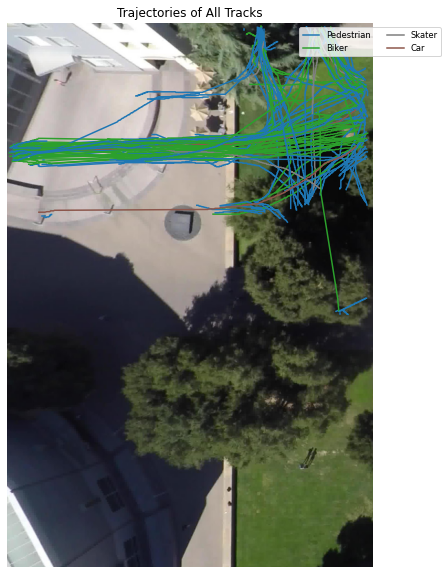

In [20]:
from matplotlib.cm import get_cmap

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the background image from the reference_image path
background_image = mpimg.imread(reference_image)

# Assign a unique color to each label
# Define a colormap
colors = get_cmap("tab10")

# Assign a unique color to each label
label_to_color = {label: colors(i / len(filtered_data["label"].unique())) for i, label in enumerate(filtered_data["label"].unique())}

# Create a figure and axis
plt.figure(figsize=(10, 10))

# Display the background image
plt.imshow(background_image, extent=[0, background_image.shape[1], background_image.shape[0], 0])

# Initialize an empty set for labeled agents
labeled_agents = set()

# Group by track and plot each trajectory
for track_id, group in filtered_data.groupby("track"):
    label = group["label"].iloc[0]
    if label not in labeled_agents:
        plt.plot(group["x"], group["y"], label=label, color=label_to_color[label])
        labeled_agents.add(label)
    else:
        plt.plot(group["x"], group["y"], color=label_to_color[label])

# Add labels and title
plt.title("Trajectories of All Tracks")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0), fontsize='small', ncol=2)

# Disable axis and grids
plt.axis('off')

# Show the plot
plt.show()


In [24]:
import imageio

# Create a directory to store the frames
os.makedirs("frames", exist_ok=True)

# Define the output GIF path
output_gif_path = "trajectories_with_background.gif"

# Generate frames for each unique frame in filtered_data
for frame_number in filtered_data["frame"].unique():
    plt.figure(figsize=(10, 10))
    plt.imshow(background_image, extent=[0, background_image.shape[1], background_image.shape[0], 0])
    
    # Filter data for the current frame
    frame_data = filtered_data[filtered_data["frame"] == frame_number]
    
    # Plot each agent in the frame
    for _, row in frame_data.iterrows():
        plt.scatter(row["x"], row["y"], color=label_to_color[row["label"]], label=row["label"], s=50)
    
    # Add title and disable axis
    plt.title(f"Frame: {frame_number}")
    plt.axis("off")
    
    # Save the frame as an image
    frame_path = f"frames/frame_{frame_number:04d}.png"
    plt.savefig(frame_path)
    plt.close()

# Collect all frame paths
frame_paths = [f"frames/frame_{frame_number:04d}.png" for frame_number in filtered_data["frame"].unique()]

# Create a GIF from the frames
with imageio.get_writer(output_gif_path, mode="I", duration=0.1) as writer:
    for frame_path in frame_paths:
        image = imageio.imread(frame_path)
        writer.append_data(image)

# Clean up the frames directory if needed
print(f"GIF saved at {output_gif_path}")

: 

In [1]:
!rm -rf frames